In [3]:
# Analyzing Returns from Geometric Brownian Motion

import math
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'

In [ ]:
# Helper function

In [4]:
def dN(x, mu, sigma):
    '''Probability density function of a normal random variable x.
    
    Parameters
    ==========
    mu: float
        expected value
    sigma: float
        standard deviation
        
    Returns
    ==========
    pdf: float
        value of probability density function
    '''
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
    return pdf

In [ ]:
# Simulate a Number of Years of Daily Stock Quotes

In [10]:
def simulate_gbm():
    # model parameters
    S0 = 100.0 # initial index level
    T = 10.0 # time horizon
    r = 0.05 # risk-less short rate
    vol = 0.2 # instantaneous volatility
    
    # simulation parameters
    np.random.seed(250000)
    gbm_dates = pd.date_range(start='30-09-2004',
                                 end='30-09-2014',
                                 freq='B')
    M = len(gbm_dates) # time steps
    I = 1 # index level paths
    dt = 1 / 252. # fixed for simplicity
    df = math.exp(-r * dt) # discount factor
    
    # stock price paths
    rand = np.random.standard_normal((M, I)) # random numbers
    S = np.zeros_like(rand) # stock matrix
    S[0] = S0 # initial values
    for t in range(1, M): # stock price paths
        S[t] = S[t-1] * np.exp((r - vol ** 2 / 2) * dt
                       + vol * rand[t] * math.sqrt(dt))
        
    gbm = pd.DataFrame(S[:, 0], index=gbm_dates, columns=['index'])
    gbm['returns'] = np.log(gbm['index'] / gbm['index'].shift(1))
    
    # Realized volatility (eg. as defined for variance swaps)
    gbm['rea_var'] = 252 * np.cumsum(gbm['returns'] ** 2) / np.arange(len(gbm))
    gbm['rea_vol'] = np.sqrt(gbm['rea_var'])
    gbm = gbm.dropna()
    return gbm
    

In [12]:
df = simulate_gbm()
df

,index,returns,rea_var,rea_vol
2004-10-01,98.904295,-0.011018,0.030589,0.174898
2004-10-04,98.444867,-0.004656,0.018026,0.134261
2004-10-05,97.696364,-0.007632,0.016911,0.130041
2004-10-06,98.280594,0.005962,0.014922,0.122158
2004-10-07,99.242342,0.009738,0.016718,0.129296
...,...,...,...,...
2014-09-24,120.239071,0.009166,0.040778,0.201937
2014-09-25,117.796679,-0.020522,0.040804,0.201999
2014-09-26,118.943586,0.009689,0.040797,0.201983
2014-09-29,119.525066,0.004877,0.040784,0.201950


In [ ]:
# Return Sample Statistics and Normality Tests

In [17]:
def print_statistics(data):
    print ("RETURN SAMPLE STATISTICS")
    print ("---------------------------------")
    print ("Mean of Daily Log Returns %9.6f" % np.mean(data['returns']))
    print ("Std of Daily Log Returns %9.6f" % np.std(data['returns']))
    print ("Mean of Annua. Log Returns %9.6f" % (np.mean(data['returns']) * 252))
    print ("Std of Annua. Log Returns %9.6f" % (np.std(data['returns']) * math.sqrt(252)))
    print ("----------------------------------")
    print ("Skew of Sample Log Returns %9.6f" % scs.skew(data['returns']))
    print("Skew Normal Test p-value %9.6f" % scs.skewtest(data['returns'])[1])
    print("------------------------------------")
    print ("Kurt of Sample Log Returns %9.6f" % scs.kurtosis(data['returns']))
    print("Kurt Normal Test p-value    %9.6f" % scs.kurtosistest(data['returns'])[1])
    print("-------------------------------------")
    print("Realized Volatility  %9.6f" % data['rea_vol'].iloc[-1])
    print("Realized Variance  %9.6f" % data['rea_var'].iloc[-1])

In [ ]:
df_print = print_statistics(df)
#df_print
#print_statistics(df)

RETURN SAMPLE STATISTICS
---------------------------------
Mean of Daily Log Returns  0.000073
Std of Daily Log Returns  0.012721
Mean of Annua. Log Returns  0.018422
Std of Annua. Log Returns  0.201944
----------------------------------
Skew of Sample Log Returns -0.016447
Skew Normal Test p-value  0.730950
------------------------------------
Kurt of Sample Log Returns  0.120578
Kurt Normal Test p-value     0.206628
-------------------------------------
Realized Volatility   0.201947
Realized Variance   0.040783


In [ ]:
# Graphical Output

In [43]:
# daily quotes and log returns
def quotes_returns(data):
    '''Plots quotes and returns.'''
    plt.figure(figsize=(9, 6))
    plt.subplot(211)
    data['index'].plot()
    plt.ylabel('daily quotes')
    plt.grid(True)
    plt.axis('tight')
    
    plt.subplot(212)
    data['returns'].plot()
    plt.ylabel('daily log returns')
    plt.grid(True)
    plt.axis('tight')
    
# histogram of annualized daily log returns
def return_histogram(data):
    '''Plots a histogram of the returns.'''
    plt.figure(figsize=(9, 5))
    x = np.linspace(min(data['returns']), max(data['returns']), 100)
    plt.hist(np.array(data['returns']), bins=50, density=True)
    y = dN(x, np.mean(data['returns']), np.std(data['returns']))
    plt.plot(x, y, linewidth=2)
    plt.xlabel('log returns')
    plt.ylabel('frequency/probability')
    plt.grid(True)
    
# Q-Q plot of annualized daily log returns
def return_qqplot(data):
    '''Generate a Q-Q plot of the returns.'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data['returns'], line='s')
    plt.grid(True)
    plt.xlabel('theoritical quantiles')
    plt.ylabel('sample quantiles')
    
# realized volatility
def realized_volatility(data):
    '''Plots the realized volatility.'''
    plt.figure(figsize=(9, 5))
    data['rea_vol'].plot()
    plt.ylabel('realized volatility')
    plt.grid(True)
    
# mean return, volatility and correlation (252 days moving = 1 year)
def rolling_statistics(data):
    '''Calculate and plots rolling statistics (mean, std, correlation).'''
    plt.figure(figsize=(11, 8))
    
    plt.subplot(311)
    mr = data['returns'].rolling(window=252).mean() * 252
    mr.plot()
    plt.grid(True)
    plt.ylabel('returns (252d)')
    plt.axhline(mr.mean(), color='r', ls='dashed', lw=1.5)
    
    plt.subplot(312)
    vo = data['returns'].rolling(window=252).std() * math.sqrt(252)
    vo.plot()
    plt.grid(True)
    plt.ylabel('volatility (252d)')
    plt.axhline(vo.mean(), color='r', ls='dashed', lw=1.5)
    vx = plt.axis()
    
    plt.subplot(313)
    co = mr.rolling(window=252).corr(vo)
    co.plot()
    plt.grid(True)
    plt.ylabel('correlation (252d)')
    cx = plt.axis()
    plt.axis([vx[0], vx[1], cx[2], cx[3]])
    plt.axhline(co.mean(), color='r', ls='dashed', lw=1.5)
    
    

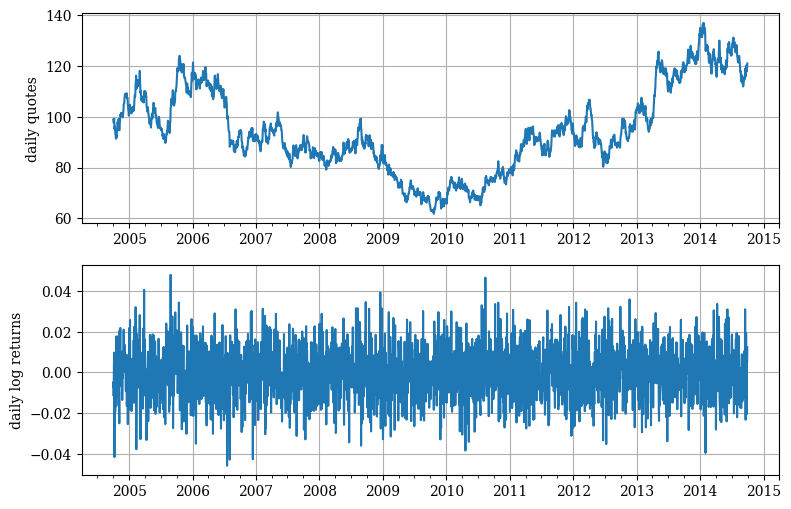

In [22]:
df_quotes = quotes_returns(df)

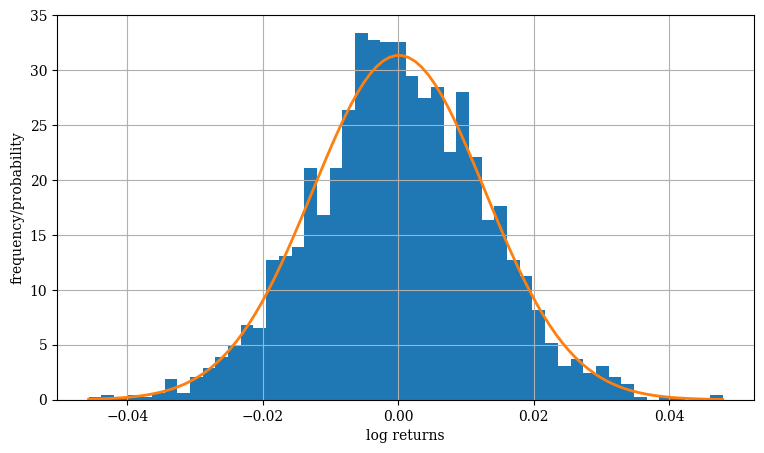

In [31]:
return_histogram(df)

<Figure size 900x500 with 0 Axes>

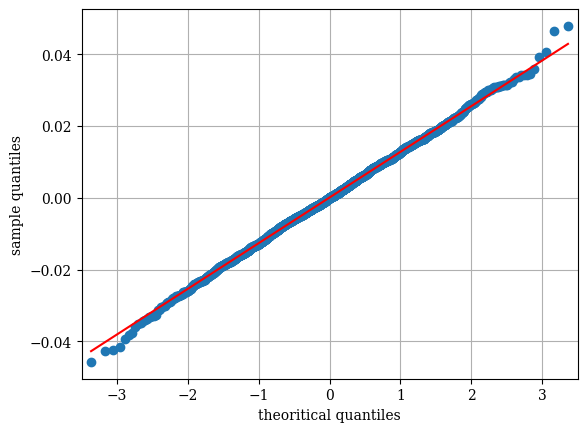

In [33]:
return_qqplot(df)

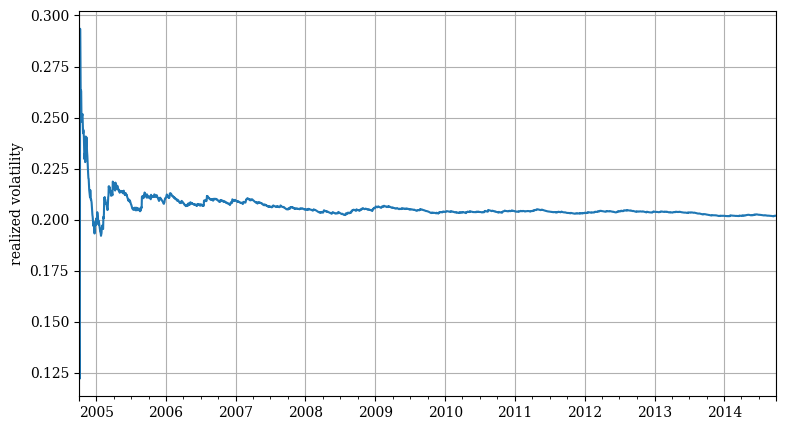

In [34]:
realized_volatility(df)

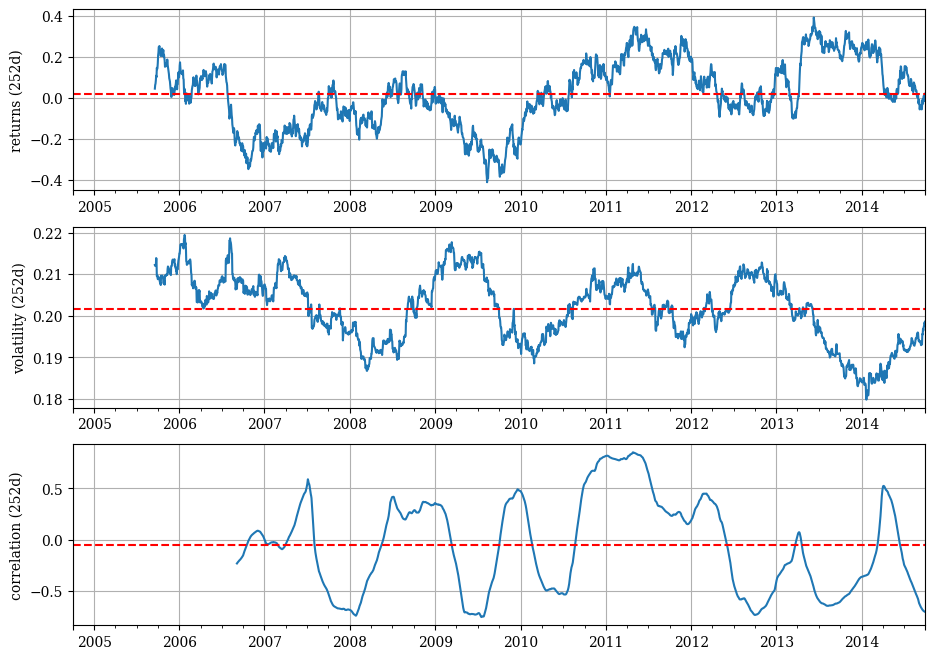

In [44]:
rolling_statistics(df)